# Evaluamos con algunas métricas

In [ ]:
# files_auc = [
#     f'{base_path}/{metric}_kernel_shap_sumcons_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
#     f'{base_path}/{metric}_linear_regression_noreg_noweights_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
#     f'{base_path}/{metric}_tree_importance_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
# ]


# ps = [0.2, 0.3, 0.4]
# ws = [1, 3, 5]
# fs = ['euclidean']
# ms = ['zeros', 'stat', 'noise']

# dfs = []
# for method, file_template in zip(methods, files_auc):
#     for p, w, f, m in itertools.product(ps, ws, fs, ms):
#         file_path = file_template.format(p, w, f, m)
#         try:
#             df = pd.read_csv(file_path, sep='\t')
#             df['method'] = method
#             df['mask_percentage'] = p
#             df['window_size'] = w
#             df['distance_function'] = f
#             df['masking_strategy'] = m
#             dfs.append(df)
#         except FileNotFoundError:
#             print(f"File not found: {file_path}")

# final_df = pd.concat(dfs, ignore_index=True)
# mean_auc_df = final_df.groupby(['method', 'mask_percentage', 'masking_strategy', 'window_size'])[value].mean().reset_index()


In [ ]:
# TITLE_SIZE = 14
# LABEL_SIZE = 12
# ANNOT_SIZE = 11
# TICK_SIZE = 12

# max_auc = mean_auc_df[value].max()
# min_auc = mean_auc_df[value].min()

# # Create a figure with subplots for each method
# methods = mean_auc_df['method'].unique()
# n_methods = len(methods)

# # Calculate number of columns and rows
# n_cols = 3  # Ceiling division to handle odd numbers
# n_rows =1

# # Create figure with adjusted size
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 7*n_rows))
# axes = axes.flatten()  # Flatten axes array for easier iteration

# # Hide extra subplots if number of methods is odd
# if n_methods < len(axes):
#     for idx in range(n_methods, len(axes)):
#         axes[idx].set_visible(False)

# for idx, method in enumerate(methods):
#     ax = axes[idx]

#     # Create pivot table for current method
#     pivot_table = mean_auc_df[mean_auc_df['method'] == method].pivot(
#         index='masking_strategy', 
#         columns=['mask_percentage', 'window_size'], 
#         values=value
#     )

#     # 🔹 Filter df_annotations for the current method
#     annotations = mean_auc_df_combination[mean_auc_df_combination['method'] == method].set_index('name')[value]

#     # 🔹 Extract values for row annotations
#     row_labels = pivot_table.index
#     row_annotations = [annotations.get(label, '') for label in row_labels]  # Get roc_auc or empty string

#     # 🔹 Extract values for column annotations
#     # col_labels = pivot_table.columns
#     # col_annotations = [annotations.get(f"{col[0]}-{col[1]}", '') for col in col_labels]  # Convert tuple to string key

#     # Create heatmap
#     sns.heatmap(
#         pivot_table,
#         annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
#         cmap="coolwarm",
#         fmt="",
#         ax=ax,
#         vmin=min_auc,
#         vmax=max_auc,
#         cbar=(idx == n_methods-1),
#         annot_kws={'size': ANNOT_SIZE}
#     )
#     all = round(mean_auc_df_combination[(mean_auc_df_combination['method'] == method) & (mean_auc_df_combination['name'] == 'all')][value].values[0], 2)
#     # all = 'not yet'
#     method = method.split('_')[0].capitalize()
#     ax.set_title(f'{metric} for {method} for {dataset}, all {all}', fontsize=TITLE_SIZE, pad=20)
#     ax.set_xlabel('Masking Strategy & Window Size', fontsize=LABEL_SIZE)
#     ax.set_ylabel('Mask Percentage', fontsize=LABEL_SIZE)

#     # Set tick label sizes
#     ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
#     ax.tick_params(axis='x', rotation=45)
#     if idx == n_methods-1:
#         cbar = plt.colorbar(ax.collections[0], ax=ax, fraction=0.02, pad=0.04)
#         cbar.ax.tick_params(labelsize=4)
#     # 🔹 **Annotate rows (masking strategies)**
#     for i, valu in enumerate(row_annotations):
#         ax.text(pivot_table.shape[1] + 0.5, i + 0.5, f"{valu:.2f}" if valu else "", 
#                 ha='center', va='center', fontsize=ANNOT_SIZE, color='black', fontweight='bold')

#     # 🔹 **Annotate columns (mask percentages & window sizes)**
#     # for j, valu in enumerate(col_annotations):
#     #     ax.text(j + 0.5, -0.5, f"{valu:.2f}" if valu else "", 
#     #             ha='center', va='center', fontsize=ANNOT_SIZE, color='black', fontweight='bold')

# plt.tight_layout()
# plt.show()


# Drums - KWS - Audioset

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

metric = 'auc_relaxed'

dataset = 'audioset_dog'
base_path = f'/home/ec2-user/evaluations/{dataset}'

if metric == 'auc':
    value = 'roc_auc'
    intersection = '0.05'
if metric == 'leo_metric':
    value = 'leo_metric'
    intersection = '0'
if metric == 'auc_relaxed':
    value = 'roc_auc'
    intersection = '0.09'

In [132]:
files_auc_complete = [
    f'{base_path}/{metric}_kernel_shap_sumcons_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_tree_importance_{{}}_{intersection}.tsv',
]

names = ["zeros", "noise"]
methods = ['kernel_shap_sumcons', 'linear_regression_noreg_noweights', 'tree_importance']

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for name in names:
        file_path = file_template.format(name)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            if method == 'tree_importance':
                df_combination['method'] = 'RF'
            if method == 'linear_regression_noreg_noweights':
                df_combination['method'] = 'LR'
            if method == 'kernel_shap_sumcons':
                df_combination['method'] = 'SHAP'
            df_combination['name'] = name
            df_combinations.append(df_combination)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            
final_df_combination = pd.concat(df_combinations, ignore_index=True)


In [133]:
len(final_df_combination['filename'].unique())

39

In [117]:
from ast import literal_eval

final_df_combination['multisegment'] = final_df_combination['true_markers'].apply(
    lambda x: 1 if len(literal_eval(x)) > 1 else 0
)

final_df_combination['group'] = final_df_combination['name'] + '-' + \
                    final_df_combination['multisegment'].astype(str)

In [118]:
mean_auc_df_combination = final_df_combination.groupby(['method', 'group'])[value].mean().reset_index()
mean_auc_df_combination

,method,group,roc_auc
0,LR,noise-0,0.794047
1,LR,noise-1,0.747886
2,LR,zeros-0,0.806079
3,LR,zeros-1,0.746923
4,RF,noise-0,0.875000
5,RF,noise-1,0.828948
6,RF,zeros-0,0.894576
7,RF,zeros-1,0.869625
8,SHAP,noise-0,0.752894
9,SHAP,noise-1,0.682187


/tmp/ipykernel_51161/653998033.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=mean_auc_df_combination,


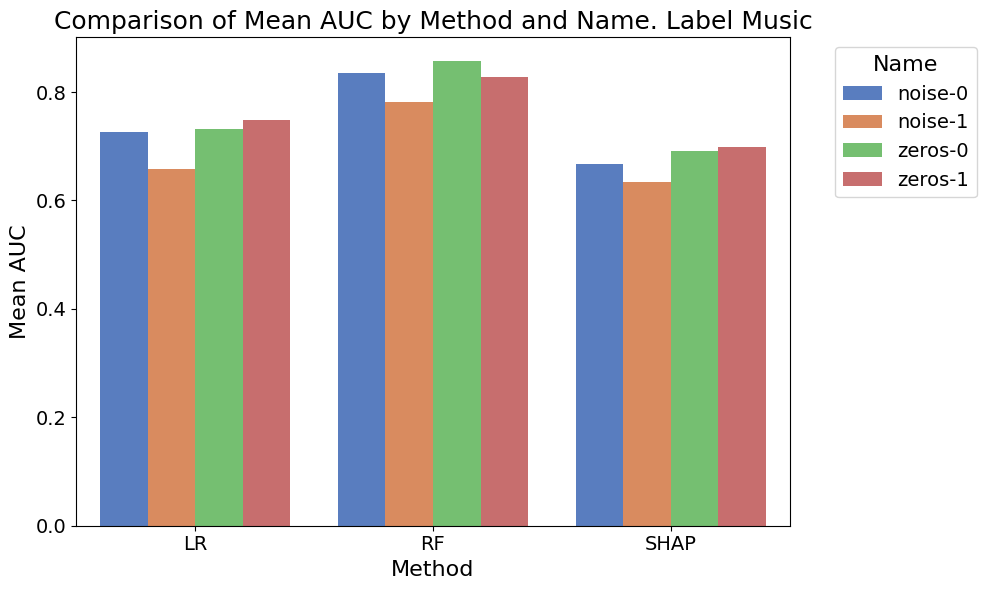

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular el promedio de AUC por método, nombre y multisegment
mean_auc_df_combination = final_df_combination.groupby(['method', 'group'])[value].mean().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))  # Ajustamos el tamaño de la figura
sns.barplot(data=mean_auc_df_combination, 
            x="method", 
            y=value, 
            hue="group",  # Agrupar por 'name' en las barras
            dodge=True,  # Para separar las barras de cada 'name'
            palette="muted",  # Estilo de colores
            ci=None)  # Sin barras de error

# Etiquetas y título con fuentes grandes
plt.xlabel("Method", fontsize=16)
plt.ylabel("Mean AUC", fontsize=16)
plt.title("Comparison of Mean AUC by Method and Name. Label Music", fontsize=18)

# Ajustar leyenda
plt.legend(title="Name", fontsize=14, title_fontsize=16, loc="upper left", bbox_to_anchor=(1.05, 1))

# Ajustar tamaño de los ticks
plt.tick_params(axis='both', labelsize=14)

# Ajustar los márgenes para que la leyenda no se corte
plt.tight_layout()

# Guardar en formato PDF
plt.savefig("mean_auc_barplot.pdf", format='pdf', bbox_inches='tight')

plt.show()


In [29]:
# Music
mean_auc_df_combination = final_df_combination.groupby(['method', 'name'])[value].mean().reset_index()
mean_auc_df_combination

,method,name,roc_auc
0,kernel_shap_sumcons,noise,0.661041
1,kernel_shap_sumcons,zeros,0.692398
2,linear_regression_noreg_noweights,noise,0.713632
3,linear_regression_noreg_noweights,zeros,0.735120
4,tree_importance,noise,0.825580
5,tree_importance,zeros,0.852002


In [32]:
# dog
mean_auc_df_combination = final_df_combination.groupby(['method', 'name'])[value].mean().reset_index()
mean_auc_df_combination

,method,name,roc_auc
0,kernel_shap_sumcons,noise,0.614393
1,kernel_shap_sumcons,zeros,0.632550
2,linear_regression_noreg_noweights,noise,0.659246
3,linear_regression_noreg_noweights,zeros,0.664088
4,tree_importance,noise,0.735488
5,tree_importance,zeros,0.774422


# Faithfulness


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

metric = 'auc_relaxed'

dataset = 'audioset_speech'
base_path = f'/home/ec2-user/evaluations/{dataset}'

if metric == 'auc':
    value = 'roc_auc'
    intersection = '0.05'
if metric == 'leo_metric':
    value = 'leo_metric'
    intersection = '0'
if metric == 'auc_relaxed':
    value = 'roc_auc'
    intersection = '0.09'

files_auc_complete = [
    f'{base_path}/{metric}_kernel_shap_sumcons_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_tree_importance_{{}}_{intersection}.tsv',
]

names = ["zeros", "noise"]
methods = ['kernel_shap_sumcons', 'linear_regression_noreg_noweights', 'tree_importance']

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for name in names:
        file_path = file_template.format(name)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            if method == 'tree_importance':
                df_combination['method'] = 'RF'
            if method == 'linear_regression_noreg_noweights':
                df_combination['method'] = 'LR'
            if method == 'kernel_shap_sumcons':
                df_combination['method'] = 'SHAP'
            df_combination['name'] = name
            df_combinations.append(df_combination)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            
final_df_combination = pd.concat(df_combinations, ignore_index=True)

In [52]:
import ast
import pandas as pd
from utils import compute_log_odds

metric = 'score_curve'
methods = ['kernel_shap_sumcons', 'linear_regression_noreg_noweights', 'tree_importance']


base_path = f'/home/ec2-user/evaluations/{dataset}'

files_auc_complete = [
    f'{base_path}/{metric}_kernel_shap_sumcons_{{}}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_{{}}.tsv',
    f'{base_path}/{metric}_tree_importance_{{}}.tsv',
]

names=['zeros', 'noise']
metric = 'score_curve'

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for name in names:
        file_path = file_template.format(name)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            if method == 'tree_importance':
                df_combination['method'] = 'RF'
            if method == 'linear_regression_noreg_noweights':
                df_combination['method'] = 'LR'
            if method == 'kernel_shap_sumcons':
                df_combination['method'] = 'SHAP'
            df_combination['name'] = name
            if dataset == 'drums':
                df_combination['actual_score'] = df_combination['actual_score'].apply(ast.literal_eval)
                df_combination['score_curve_sacando_topk'] = df_combination['score_curve_sacando_topk'].apply(ast.literal_eval)
                df_combination['event_label'] = df_combination['event_label'].apply(int)

                df_combination['log_odds'] = df_combination['actual_score'].apply(compute_log_odds)
                df_combination['log_odds_curve'] = df_combination['score_curve_sacando_topk'].apply(compute_log_odds)

                percentages = [0.01, 0.05, 0.1, 0.20, 0.5]
                for i in percentages:
                    df_combination[f'top_{i}'] = df_combination.apply(
                        lambda row: row['log_odds'][row['event_label']] - row['log_odds_curve'][int(len(row['score_curve_sacando_topk']) * i)][row['event_label']],
                        axis=1
                    )
            else: 
                df_combination['actual_score'] = df_combination['actual_score'].apply(ast.literal_eval)
                df_combination['score_curve_sacando_topk'] = df_combination['score_curve_sacando_topk'].apply(ast.literal_eval)
                df_combination['event_label'] = df_combination['event_label'].apply(int)

                df_combination['log_odds'] = df_combination['actual_score']
                df_combination['log_odds_curve'] = df_combination['score_curve_sacando_topk']

                percentages = [0.01, 0.05, 0.1, 0.20, 0.5]
                for i in percentages:
                    df_combination[f'top_{i}'] = df_combination.apply(
                        lambda row: row['log_odds'][row['event_label']] - row['log_odds_curve'][int(len(row['score_curve_sacando_topk']) * i)][row['event_label']],
                        axis=1
                    )

        except FileNotFoundError:
            print(f"File not found: {file_path}")

        df_combinations.append(df_combination)
            
final_df_combination_ff = pd.concat(df_combinations, ignore_index=True)

In [39]:
final_df_combination = final_df_combination.drop_duplicates()

In [49]:
final_df_combination_ff = final_df_combination_ff[final_df_combination_ff['filename'].isin(final_df_combination['filename'])]
final_df_combination = final_df_combination[final_df_combination['filename'].isin(final_df_combination_ff['filename'])]

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


corr1, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.01'])
corr5, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.05'])
corr10, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.1'])
corr20, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.2'])
corr50, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.5'])

print(f'Correlation for dataset {dataset}')
print(f'Correlation 1% {corr1}')
print(f'Correlation 5% {corr5}')
print(f'Correlation 10% {corr10}')
print(f'Correlation 20% {corr20}')
print(f'Correlation 50% {corr50}')

Correlation for dataset audioset_speech
Correlation 1% 0.301291652444833
Correlation 5% 0.4137539022583677
Correlation 10% 0.4577426803103284
Correlation 20% 0.4846446039974264
Correlation 50% 0.49371479902345156


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


corr1, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.01'])
corr5, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.05'])
corr10, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.1'])
corr20, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.2'])
corr50, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.5'])

print(f'Correlation for dataset {dataset}')
print(f'Correlation 1% {corr1}')
print(f'Correlation 5% {corr5}')
print(f'Correlation 10% {corr10}')
print(f'Correlation 20% {corr20}')
print(f'Correlation 50% {corr50}')

Correlation for dataset audioset_music
Correlation 1% 0.08532767626148154
Correlation 5% 0.2509339307135954
Correlation 10% 0.3397304341339141
Correlation 20% 0.442783272425104
Correlation 50% 0.40793838522906967


In [43]:


corr1, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.01'])
corr5, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.05'])
corr10, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.1'])
corr20, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.2'])
corr50, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.5'])

print(f'Correlation for dataset {dataset}')
print(f'Correlation 1% {corr1}')
print(f'Correlation 5% {corr5}')
print(f'Correlation 10% {corr10}')
print(f'Correlation 20% {corr20}')
print(f'Correlation 50% {corr50}')

Correlation for dataset drums
Correlation 1% -0.009602052425597439
Correlation 5% -0.13320781643861282
Correlation 10% -0.016980488151489528
Correlation 20% 0.12544316910787995
Correlation 50% 0.13035240347799065


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


corr1, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.01'])
corr5, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.05'])
corr10, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.1'])
corr20, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.2'])
corr50, _ = pearsonr(final_df_combination['roc_auc'], final_df_combination_ff['top_0.5'])

print(f'Correlation for dataset {dataset}')
print(f'Correlation 1% {corr1}')
print(f'Correlation 5% {corr5}')
print(f'Correlation 10% {corr10}')
print(f'Correlation 20% {corr20}')
print(f'Correlation 50% {corr50}')

Correlation for dataset audioset_dog
Correlation 1% 0.4019923934898352
Correlation 5% 0.4014369831285056
Correlation 10% 0.4046736785390324
Correlation 20% 0.3807179803715562
Correlation 50% 0.42779877233302543


In [28]:
top_k_values = [1, 3, 5, 10]

# Compute the mean for each top_k value grouped by 'method' and 'name'
mean_auc_df_combination = final_df_combination.groupby(['method', 'name'])[
    [f'top_{i}' for i in top_k_values]
].mean().reset_index()

mean_auc_df_combination.to_csv(f'/home/ec2-user/evaluations/{dataset}/faithfulness.csv', index=False)

# Drums test

In [40]:
base_path = f'/home/ec2-user/evaluations/drums'
metric = 'order'
names = ["zeros", "noise"]
methods = ['kernel_shap_sumcons', 'linear_regression_noreg_noweights', 'tree_importance']

files_auc_complete = [
    f'{base_path}/{metric}_kernel_shap_sumcons_{{}}_{{}}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_{{}}_{{}}.tsv',
    f'{base_path}/{metric}_tree_importance_{{}}_{{}}.tsv',
]
names = ["zeros", "noise"]

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for i in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]:
        for name in names:
            file_path = file_template.format(name, i)
            try:
                df_combination = pd.read_csv(file_path, sep='\t')
                if method == 'tree_importance':
                    df_combination['method'] = 'RF'
                if method == 'linear_regression_noreg_noweights':
                    df_combination['method'] = 'LR'
                if method == 'kernel_shap_sumcons':
                    df_combination['method'] = 'SHAP'
                df_combination['name'] = name
                df_combination['final'] = i
                df_combinations.append(df_combination)
            except FileNotFoundError:
                print(f"File not found: {file_path}")
                
final_df_combination = pd.concat(df_combinations, ignore_index=True)


In [56]:
final_df_combination['group'] = final_df_combination['method'] + '-' + \
                    final_df_combination['name'].astype(str)
final_df_combination = final_df_combination[final_df_combination['final'] != 0.1]

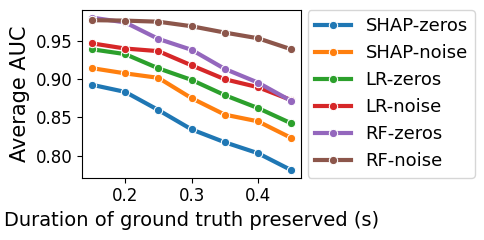

In [83]:
plt.figure(figsize=(5, 2.5))  # Hacemos el gráfico más compacto
sns.lineplot(data=final_df_combination, 
            x="final", 
            y="roc_auc", 
            hue="group", 
            marker="o",
            errorbar=None,
            linewidth=3)  # Líneas más gruesas

# Labels y título con fuentes grandes
plt.xlabel("Duration of ground truth preserved (s)", fontsize=14)
plt.ylabel("Average AUC", fontsize=15)

# Leyenda afuera y a lo largo
plt.legend(bbox_to_anchor=(1.03, 1), 
          loc='upper left', 
          borderaxespad=0.,
          fontsize=13)

plt.tick_params(axis='both', labelsize=12)  # Números de los ejes más grandes

# Ajustar los márgenes para que la leyenda no se corte
plt.tight_layout()

# Guardar en formato PDF sin márgenes adicionales
plt.savefig("drums_curves.pdf", format='pdf', bbox_inches='tight')

plt.show()

